In [1]:
import json
import numpy as np 
import xarray as xr
import seaborn as sns
from glob import glob
import os.path as path
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
from thermal.plotting import enthalpy_pcolormesh
from thermal.derived_fields import (calc_length,
                                    calc_mean_enthalpy,
                                    calc_percent_temperate)


plt.rcParams.update({'font.size': 12, 
                     'text.usetex': True})
def preprocess(src): 
    # filename 
    fn = src.encoding['source']
    # remove the file extension 
    bn = path.splitext(src.encoding['source'])[0]
    
    # parse the parameter values
    param, value = parse_params(bn)
    
    # expand the dimmension along parameter values to concatentate along
    src = src.expand_dims(param).assign_coords({param: (param, [float(value)])})
    
    return src

In [2]:
ssd_fp = '/Volumes/Thermal_GEF/thermal-structure/expr/01_UQ/result/crmpt12/gridded/'

In [3]:
def parse_params(run_name): 
    info = run_name.split('1aTST_')[-1]
    
    param = '_'.join(info.split('_')[:-1])
    value = info.split('_')[-1]
    
    return param, value

def preprocess(ds): 
    file_name = ds.encoding["source"]
    base_name   = path.basename(file_name)
    run_name, _ = path.splitext(base_name)
    
    param, value = parse_params(run_name)
    
    # ds = ds.expand_dims('param').assign_coords({'param' : ('param', [param])})
    ds = ds.expand_dims(param).assign_coords({param: (param, [float(value)])})
    
    return ds

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        # Note also that we must extrapolate beyond vmin/vmax
        center = np.abs(self.vcenter / (self.vmax-self.vmin))
        x, y = [self.vmin, self.vcenter, self.vmax], [0, center, 1.]
        return np.ma.masked_array(np.interp(value, x, y,
                                            left=-np.inf, right=np.inf))

    def inverse(self, value):
        y, x = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.interp(value, x, y, left=-np.inf, right=np.inf)



In [4]:
files = []

for file in glob(ssd_fp + '*.zarr'): 
    base_name   = path.basename(file)
    run_name, _ = path.splitext(base_name)
    
    param, value = parse_params(run_name)
    
    if param == '': 
        continue 
    if value == '.zarr':
        continue   
    if param != 'f_dd': 
        continue
        
    files.append(file)
    
    

In [5]:
def find_files(ssd_fp, param): 
    files = []
    
    target = param
    
    for file in glob(ssd_fp + '*.zarr'): 
        base_name   = path.basename(file)
        run_name, _ = path.splitext(base_name)

        param, value = parse_params(run_name)
        
        if param == '':
            continue 
        if value == '':
            continue
        if param != target: 
            continue

        files.append(file)
        
    return files


sorter = lambda x: float(path.splitext(parse_params(x)[-1])[0])

/var/folders/g3/nkh04ckd39jcftknlklg_vnh0000gn/T/ipykernel_25905/2926502268.py:13: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  src = xr.open_zarr(fn)


AttributeError: 'Dataset' object has no attribute 'relative_volume'

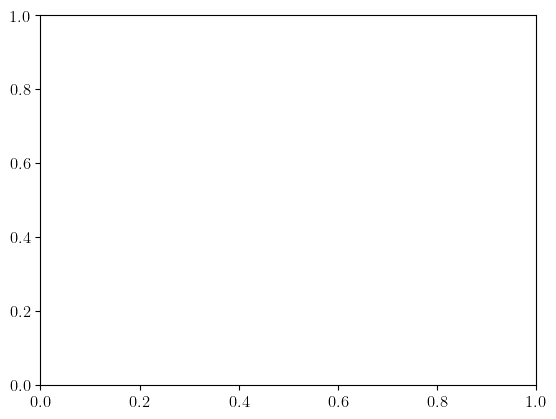

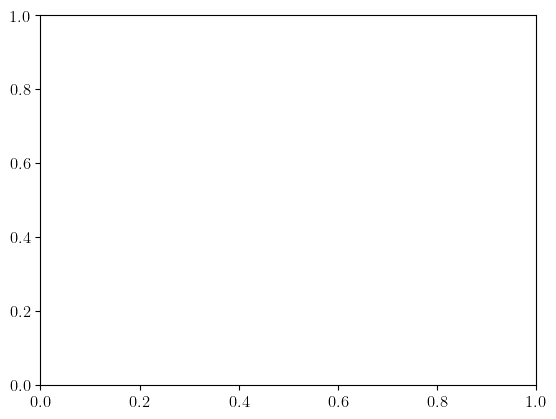

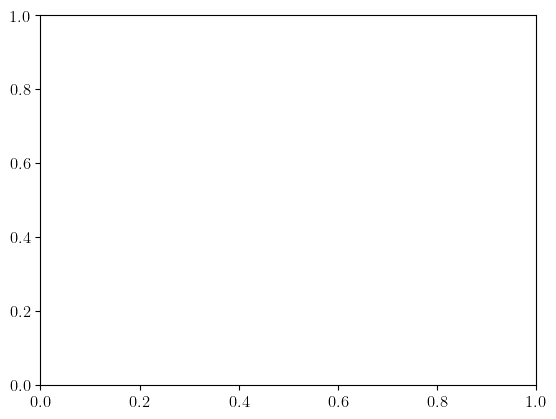

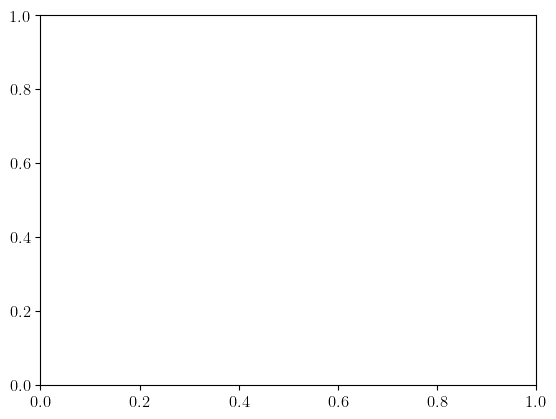

In [61]:
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()


for fn in sorted(files): 
    base_name   = path.basename(fn)
    run_name, _ = path.splitext(base_name)
    
    param, value = parse_params(run_name)
    
    src = xr.open_zarr(fn)
    v_prime = src.relative_volume / src.relative_volume[0]
    v_prime.plot(x='t', ax=ax1, label=value)
    
    
    src['percent_temperate'].plot(x='t', ax=ax2, label=value)

    H_bar = calc_mean_enthalpy(src)
                               
    H_bar.plot(x='t', ax=ax3)

    ax4.plot(src.X[0,::-1], src.Z.isel(t=-1, coord_2=-1))
     
ax1.set_ylim(None, 2.0)
fig1.legend()

(<Figure size 600x300 with 2 Axes>,
 <AxesSubplot: >,
 <matplotlib.colorbar.Colorbar at 0x13e659a00>)

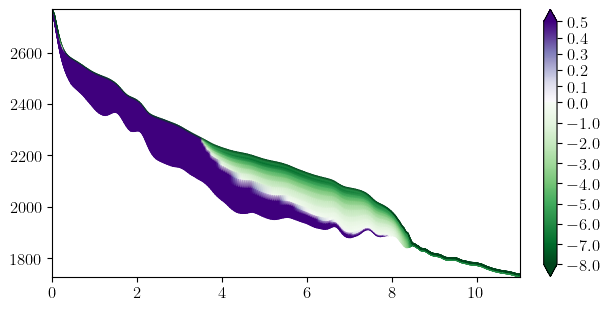

In [7]:
enthalpy_pcolormesh(src, -1)

In [8]:
def make_colorbar(array, ref, IC=False): 
    
    pmin = array.min()
    pmax = array.max()
    pmid = ref
    pN   = array.size
    
    if not IC: 
        norm  = colors.TwoSlopeNorm(vmin=pmin, vcenter=pmid, vmax=pmax)
        cmap  = plt.matplotlib.cm.RdBu_r

    else: 
        norm  = colors.Normalize(vmin=pmin, vmax=pmax)
        cmap  = plt.matplotlib.cm.Blues_r
        Blues_r = cmap.resampled(256)
        updated = Blues_r(np.linspace(0,1,256))
        black   = np.array([0, 0, 0, 1])
        updated[-23:, :] = black
        cmap = colors.ListedColormap(updated)
        
    s_map = plt.matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    s_map.set_array(array)
    
    dp    = np.diff(array)
    left  = np.round(array[:-1] - dp/2, 2) 
    right = np.round(array[1:]  + dp/2, 2)

    bounds = np.union1d(left, right)

    return cmap, norm, s_map, bounds

In [9]:
formatting = {
    'C_firn' : {'scale' : 1,    'latex' : '$C$',                'units' : r'm$^{-1}$'}, 
    'f_dd'   : {'scale' : 1000, 'latex' : r'$f_{\rm dd}$',      'units' : r'mm w.e. K$^{-1}$ d$^{-1}$'},   
    'w_en'   : {'scale' : 100,  'latex' : r'$\omega_{\rm en}$', 'units' : r'\%'}, 
    'w_aq'   : {'scale' : 100,  'latex' : r'$\omega_{\rm aq}$', 'units' : r'\%'}, 
    'IC'     : {'scale' : 1,    'latex' : 'IC',                 'units' : r'$^\circ$ C'} }

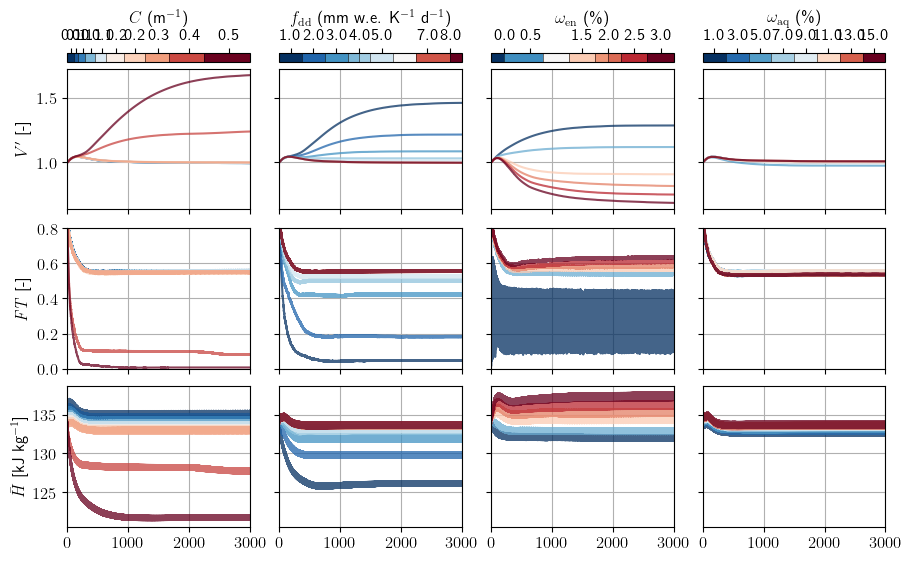

In [10]:
fig, ax = plt.subplots(3,4, figsize=(9, 5.5), sharex=True, sharey='row',
                       constrained_layout=True)

with open('params/crmpt12.json') as f: 
    param_dict = json.load(f)['params']
    
    
for i, param in enumerate(['C_firn', 'f_dd', 'w_en', 'w_aq']): 
 
    # get the reference value for the current parameter
    ref = param_dict[param]['reference'] * formatting[param]['scale']

    # fing the files
    files = find_files(ssd_fp, param)
    # sort the files 
    files.sort(key=sorter)
    
    # load all the files found into a single dataset
    ds = xr.open_mfdataset(files, engine='zarr', preprocess=preprocess, parallel=True)
    # rescale the parameter values to be better for figures
    ds[param] = ds[param] * formatting[param]['scale']
    
    # make the discrete colorbar, which should capture each individual parameter tested
    cmap, norm, s_map, bounds = make_colorbar(ds[param], ref)
    
    # make the volume relative
    v_prime = ds.relative_volume / ds.relative_volume.isel(t=0)
    
    # recalculate the fraction temperate
    FT = calc_percent_temperate(ds).chunk('auto').compute() / 100
    
    # calculate the mean enthalpy 
    H_bar = calc_mean_enthalpy(ds).chunk('auto').compute() / 1e3
    
    for p in ds[param]: 

        if float(p) == ref: 
            color='k'
        else: 
            color=cmap(norm(float(p)))
            
            
        ax[0,i].plot(v_prime.sel({param:p}).t, 
                     v_prime.sel({param:p}), 
                     alpha=0.75, c=color)
        
        ax[1,i].plot(FT.sel({param:p}).t,      
                     FT.sel({param:p}), 
                     alpha=0.75, c=color)
        
        ax[2,i].plot(H_bar.sel({param:p}).t, 
                     H_bar.sel({param:p}), 
                     alpha=0.75, c=color)
        
        
    cbar = fig.colorbar(s_map,
                    ax=ax[0,i], 
                    spacing='proportional',
                    ticks=s_map.get_array(),
                    boundaries=bounds,
                    drawedges=True,
                    location='top', 
                    format="{x:.1f}"
                   )
    cbar.set_label(formatting[param]['latex'] + '  (' + formatting[param]['units'] + ')')
    # cbar.set_ticklabels(cbar.get_ticks(), fontsize='small')
                
    ax[0, i].grid()
    ax[1, i].grid()
    ax[2, i].grid()
    
# set the shared axis bounds
ax[0,i].set_xlim(0.00, 3000)
# ax[0,i].set_ylim(0.60, 2.00)
ax[1,i].set_ylim(0.00, 0.8)

# set the y-axis label 
ax[0,0].set_ylabel("$V'$ [-]")
ax[1,0].set_ylabel(r'$\mathit{FT}$ [-]');
ax[2,0].set_ylabel(r'$\bar{H}$ [kJ kg$^{-1}$]');


# fig.savefig('figs/crmpt12/test.png', dpi=600)

In [11]:
fig.savefig('figs/crmpt12/test.png', dpi=600)

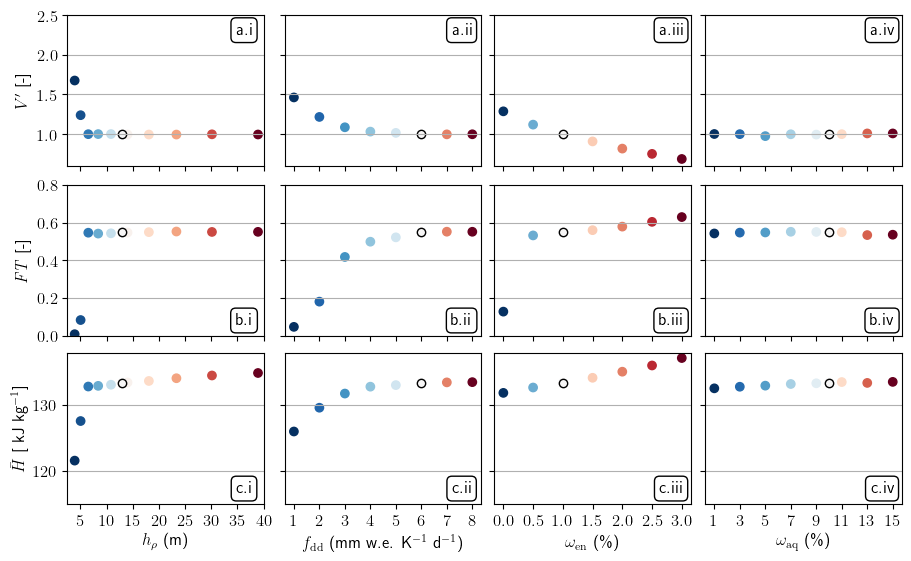

In [69]:
fig, ax = plt.subplots(3,4, figsize=(9, 5.5), sharey='row', sharex='col',
                       constrained_layout=True)

with open('params/crmpt12.json') as f: 
    param_dict = json.load(f)['params']
    
rho_f = 830.
rho_i = 910.
rho_s = 350.
close_off = lambda C : -(1/C) * np.log((rho_f - rho_i) / -(rho_i - rho_s))

# this is wacky, but neeeded to properly plot the reference value, 
# for the runs which don't actually sample the referecne value (e.g. C_firn, w_aq)
for i, param in zip([0, 1, 3, 2], ['C_firn', 'f_dd', 'w_aq','w_en']): 
 
    # get the reference value for the current parameter
    ref = param_dict[param]['reference'] * formatting[param]['scale']

    # fing the files
    files = find_files(ssd_fp, param)
    # sort the files 
    files.sort(key=sorter)
    
    # load all the files found into a single dataset
    ds = xr.open_mfdataset(files, engine='zarr', preprocess=preprocess, parallel=True)
    # make the volume relative
    ds['relative_volume'] = ds.relative_volume / ds.relative_volume.isel(t=0)
    
    if param == 'C_firn': 
        ds[param] = close_off(ds[param])
        ref = close_off(0.15)
    else: 
        # rescale the parameter values to be better for figures
        ds[param] = ds[param] * formatting[param]['scale']
    
    #only need the final timestep in this case
    ds = ds.sel(t=2900, method='nearest', tolerance=100)
    
    v_prime = ds.relative_volume
    
    # recalculate the fraction temperate
    FT = calc_percent_temperate(ds) / 100
    
    # calculate the mean enthalpy 
    H_bar = calc_mean_enthalpy(ds) / 1e3
    
    # make the discrete colorbar, which should capture each individual parameter tested
    cmap, norm, s_map, bounds = make_colorbar(ds[param], ref)
    

    # do the plotting 
    ax[0,i].scatter(ds[param], v_prime, 
                    c=ds[param], cmap=cmap, norm=norm)

    ax[1,i].scatter(ds[param], FT,      
                    c=ds[param], cmap=cmap, norm=norm)
    
    ax[2,i].scatter(ds[param], H_bar,  
                    c=ds[param], cmap=cmap, norm=norm)
            
    
    # replot the refernce so it can have it's special marker 
    if (param != 'C_firn') & (param != 'w_aq'): 
        ax[0,i].scatter(ref, v_prime.sel({param:ref}), c=ref, 
                        cmap=cmap, norm=norm, edgecolor='k')

        ax[1,i].scatter(ref, FT.sel({param:ref}), c=ref,      
                        cmap=cmap, norm=norm, edgecolor='k')

        ax[2,i].scatter(ref, H_bar.sel({param:ref}), c=ref,   
                        cmap=cmap, norm=norm, edgecolor='k')
            
    ax[0, i].grid(axis='y')
    ax[1, i].grid(axis='y')
    ax[2, i].grid(axis='y')
    
    if param != 'C_firn': 
        ax[2,i].xaxis.set_ticks(np.linspace(ds[param].min(), ds[param].max(),  param_dict[param]['samples']))
        ax[2,i].set_xlabel(formatting[param]['latex'] + '  (' + formatting[param]['units'] + ')')
    else: 
        ax[2,i].set_xlim(2.5,40)
        ax[2,i].xaxis.set_ticks(np.linspace(5, 40, 8))
        ax[2,i].set_xlabel(r'$h_{\rm \rho}$ (m)')
      
# hacky way to plot the reference for C_firn

for i, x in zip([0,3], [close_off(0.15), 10]): 
    
    ax[0,i].scatter(x, v_prime.sel({param:ref}), c=ref, 
                    cmap=cmap, norm=norm, edgecolor='k')
    ax[1,i].scatter(x, FT.sel({param:ref}), c=ref,      
                    cmap=cmap, norm=norm, edgecolor='k')
    ax[2,i].scatter(x, H_bar.sel({param:ref}), c=ref,   
                    cmap=cmap, norm=norm, edgecolor='k')

rows = ['a', 'b', 'c', 'd']
cols = ['i', 'ii', 'iii', 'iv']
for i in range(ax.shape[0]): 
    for j in range(ax.shape[1]): 
        label = rows[i] + '.'+ cols[j]
        
        if i == 0: 
            coords = (0.9, 0.9)
        else: 
            coords = (0.9, 0.1) 
            
        ax[i,j].text(*coords, label, 
                     ha='center', va='center', transform=ax[i, j].transAxes, 
                     bbox=dict(boxstyle="round", fc='w') )
    
# set the shared axis bounds
# ax[0,i].set_xlim(0.00, 3000)
ax[0,i].set_ylim(0.60, 2.50)
ax[1,i].set_ylim(0.00, 0.8)
ax[2,i].set_ylim(115., None)

# set the y-axis label 
ax[0,0].set_ylabel("$V'$ [-]")
ax[1,0].set_ylabel(r'$\mathit{FT}$ [-]');
ax[2,0].set_ylabel(r'$\bar{H}$ [ kJ kg$^{-1}$]');


# fig.savefig('figs/crmpt12/test@3kya.png', dpi=600)
fig.savefig('figs/crmpt12/Parametric_test_at_3kya.pdf')

In [ ]:
nz_15 = '/Volumes/thermal_ssd/new_1aTST/crmpt12_dx_50_NT_30000_dt_0.1_1aTST_f_dd_0.006.zarr/'
nz_30 = '/Volumes/thermal_ssd/new_1aTST/crmpt12_dx_50_NT_30000_dt_0.1_1aTST_NZ_30.zarr/'

In [ ]:
for fn in [nz_15, nz_30]:  
    src = xr.open_zarr(fn)
    
    v_prime = src.relative_volume / src.relative_volume[0]
    
    # src.percent_temperate.plot()
    
    
    # print(float(np.mean(src.vel_m.isel(t=-1))))
    
    L = calc_length(src.isel(t=-1).compute())
    
    # get the vertical gridcell spacing, but only within the ice domain
    dz = src.isel(t=-1).where(lambda x: x.X[-1] > L*1e3).Z.diff('coord_2').values[:,::2].flatten()

    sns.kdeplot(src.vel_z.isel(t=-1).values.flatten())

In [ ]:
fig, ax, cbar = enthalpy_pcolormesh(src, -2)

# fig.savefig('figs/crmpt12/pcolormesh_C_firn_0.5_@3ka.png', dpi=400)

# Degree-Day Factor

In [ ]:
def preprocess(src): 
    # filename 
    fn = src.encoding['source']
    # remove the file extension 
    bn = path.splitext(src.encoding['source'])[0]
    
    # parse the parameter values
    param, value = parse_params(bn)
    
    # expand the dimmension along parameter values to concatentate along
    src = src.expand_dims(param).assign_coords({param: (param, [float(value)])})
    
    return src

f_dd_ds = xr.open_mfdataset(ssd_fp+'*_f_dd*.zarr', engine='zarr', data_vars='minimal', preprocess=preprocess)
# rescale the parameter values to be better for figures
f_dd_ds['f_dd'] = f_dd_ds.f_dd * formatting['f_dd']['scale']
# get the reference value for the current parameter
ref = param_dict['f_dd']['reference'] * formatting['f_dd']['scale']

In [ ]:
Z = f_dd_ds.isel(t=-500, coord_2=-1).Z
M = f_dd_ds.isel(t=slice(-500,-490),coord_2=-1).surf_melt
R = f_dd_ds.isel(t=slice(-500,-490),coord_2=-1).runoff_frac


In [ ]:
fig, ax = plt.subplots(2,1, sharex=True)

# make the discrete colorbar, which should capture each individual parameter tested
cmap, norm, s_map, bounds = make_colorbar(f_dd_ds.f_dd, ref)

for f_dd in f_dd_ds.f_dd: 
    
    color = cmap(norm(float(f_dd)))
                 
    ax[0].plot(Z.sel(f_dd=f_dd), M.sel(f_dd=f_dd).sum('t'), color=color)
    
    ax[1].plot(Z.sel(f_dd=f_dd), (M*R).sel(f_dd=f_dd).sum('t'), color=color)
    

cbar = fig.colorbar(s_map,
                    ax=ax, 
                    spacing='proportional',
                    ticks=s_map.get_array(),
                    boundaries=bounds,
                    drawedges=True,
                    format="{x:.1f}", 
                    label='Degree day factor for snow'
                   )


ax[0].set_ylabel('Melt (m a${-1}$)')
ax[1].set_ylabel('Runoff (m a${-1}$)')
ax[1].set_xlabel('Elevation [m a.s.l.]')

ax[0].set_ylim(0, None)
ax[1].set_ylim(0, None)
ax[1].set_xlim(2250, 2750)

fig.savefig('figs/crmpt12/melt_curves.png', dpi=600)


In [ ]:
f_dd = 2.0


fig, ax = plt.subplots(5,1, sharex=True, sharey=True, 
                       figsize=(5,9))

for i, f_dd in enumerate(f_dd_ds.f_dd[:5][::-1]):

    im = enthalpy_pcolormesh(f_dd_ds.sel(f_dd=f_dd), -500, axes=ax[i])
    
    label = r'$f_{\rm dd}$ = ' + f'{float(f_dd):.1f}' + r'  (mm w.e. C$^{-1}$ d$^{-1}$)'
    
    ax[i].text(0.75, 0.7, label,
               ha='center', va='center', transform=ax[i].transAxes)
    
# ax.axvline(1.0)

fig.savefig('figs/crmpt12/distributed_crmpt12.png', dpi=600)

In [ ]:
f_dd_ds.isel(f_dd=0).relative_volume

In [ ]:
plt.pcolormesh(f_dd_ds.isel(f_dd=6).X[:,::-1],
               f_dd_ds.isel(f_dd=6).Z.isel(t=-1),  
               (f_dd_ds.enthalpy_h.sel(f_dd=3) - f_dd_ds.enthalpy_h.sel(f_dd=2.6)).isel(t=-1), 
               shading='gouraud')

In [ ]:
plt.pcolormesh(f_dd_ds.isel(f_dd=6).X[:,::-1],
               f_dd_ds.isel(f_dd=6).Z.isel(t=1),  
               f_dd_ds.vel_z.sel(f_dd=3).isel(t=-1), 
               vmin=-5, vmax=5, cmap='RdBu',
               shading='gouraud')

plt.colorbar()

# Firn aquifer 

In [ ]:
from thermal.gradient import calc_gradient
w_aq_ds = xr.open_mfdataset(ssd_fp+'*w_aq*.zarr', engine='zarr', preprocess=preprocess)

In [ ]:
w_aq_ds['relative_volume'] = w_aq_ds.relative_volume / w_aq_ds.relative_volume.isel(t=0)

In [ ]:
omega_min = w_aq_ds.percent_temperate.isel(t=-1).min()
omega_max = w_aq_ds.percent_temperate.isel(t=-1).max()

print(float(omega_max - omega_min))

In [ ]:
var = ['enthalpy_h', 'Z', 'X']
ref = w_aq_ds[var].isel(t=slice(-10,None), w_aq=2).compute()
sub = w_aq_ds[var].isel(t=slice(-10,None), w_aq=[0,-1]).compute()

In [ ]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(9,6))

ref_H = ref.enthalpy_h.mean('t')
ref_dHdz, ref_dHdx = calc_gradient(ref_H, ref.Z.isel(t=-1), ref.X)


for i, w_aq in enumerate(sub.w_aq): 
    subsub = sub.sel(w_aq=w_aq)
    
    H = subsub.enthalpy_h.mean('t')
    dHdz, dHdx = calc_gradient(H, subsub.Z.isel(t=-1), subsub.X)

    ax[i, 0].pcolormesh(subsub.X[:, ::-1], 
                      subsub.Z.isel(t=-1), 
                     (H - ref_H)/1e3, 
                     cmap='RdBu', vmin=-5, vmax=5, 
                     shading='gouraud')
    
    
    ax[i, 1].pcolormesh(subsub.X[:, ::-1], 
                     subsub.Z.isel(t=-1), 
                     (dHdz- ref_dHdz)/1e3, 
                     cmap='RdBu', vmin=-5, vmax=5, 
                     shading='gouraud')
    
    print((dHdz- ref_dHdz).min()/1e3)

# Firn density profile

In [ ]:
C     = 0.05 
rho_f = 830.0
rho_s = 350.0
rho_i = 910.0

close_off = lambda C : -(1/C) * np.log((rho_f - rho_i) / -(rho_i - rho_s))

rho = lambda d, C=0.15: rho_i - [rho_i - rho_s]*np.exp(-C * d)

In [ ]:
C_firn_ds = xr.open_mfdataset(ssd_fp+'*C_firn*.zarr', engine='zarr', preprocess=preprocess)
ref = xr.open_zarr(ssd_fp+"../crmpt12/thinned/crmpt12_dx_50_NT_30000_dt_0.1_MB_-0.37_OFF_Tma_-8.5_prog.zarr")

In [ ]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True)



idxs = [0,2]
for i, C_firn in zip([0,2], C_firn_ds.C_firn[[0,-1]]): 
    
    sub = C_firn_ds.sel(C_firn=C_firn).isel(t=-1)
    
    d   = sub.where(sub['mass balance'] >=0).depth.mean('coord_1')
    d_int = np.linspace(0, 50, 100)
    rho_int = rho(d_int, C_firn.values)
    
    ax[i].plot(rho_int, d_int)
    ax[i].hlines(d, 350, 910, color='k', lw=0.5, alpha=0.75)

    ax[i].axhline(close_off(C_firn))
    
    ax[i].set_title(r'$h_{\rho}$ = ' + f'{close_off(C_firn):.1f}')
    
    print(float(d.isel(coord_2=0).squeeze()))
 
# plot the reference data
d   = ref.where(ref['mass balance'] >=0).isel(t=-1).depth.mean('coord_1')
rho_int = rho(d_int, 0.15)

ax[1].plot(rho_int, d_int)
ax[1].hlines(d, 350, 910, 
             color='k', lw=0.5, alpha=0.75)

ax[1].axhline(close_off(0.15))
ax[1].set_title(r'$h_{\rho}$ = ' + f'{close_off(0.15):.1f}')

    
print(float(d.isel(coord_2=0).squeeze()))

    
for axes in ax: 
    axes.axvline(rho_f, c='k', ls=":", lw=1.0)
    
ax[0].invert_yaxis()
ax[0].set_ylim(50, -1)
ax[0].set_xlim(350, 910)


plt.savefig('figs/crmpt12/c_firn.png', dpi=600)

In [ ]:
fig, ax = plt.subplots(5,1, sharex=True, sharey=True, 
                       figsize=(5,9))

for i, C_firn in enumerate(C_firn_ds.C_firn[-5:]):

    im = enthalpy_pcolormesh(C_firn_ds.sel(C_firn=C_firn), -500, axes=ax[i])
    
    label = r'$h_{\rho}$ = ' + f'{float(close_off(C_firn)):.1f}' + ' (m)'
    
    ax[i].text(0.8, 0.7, label,
               ha='center', va='center', transform=ax[i].transAxes)
    
plt.savefig('figs/crmpt12/distributed_c_firn.png', dpi=600)

In [ ]:
close_off(0.05)

In [ ]:
diff = (C_firn_ds.isel(C_firn=0,t=-1) - C_firn_ds.isel(C_firn=0,t=-1)).enthalpy_h 

# mask = lambda x: xr.where(x.enthalpy_h >= x['phase change enthalpy'], 1, 0)
mask = lambda x: xr.where(x['water content'] >= 0.001, 1, 0)

plt.scatter(C_firn_ds.isel(C_firn=0,t=-1).X[::-1], 
            C_firn_ds.isel(C_firn=0,t=-1).Z, 
            c=mask(C_firn_ds.isel(C_firn=1,t=-1)),
            s=1.)
              

In [ ]:
close_off(C_firn_ds.isel(C_firn=-1).C_firn)

# Initial condition 

In [6]:
IC_ds = xr.open_mfdataset(ssd_fp+'*IC*.zarr', engine='zarr', preprocess=preprocess)
ref = 0.0

# make the volume relative 
IC_Vprime = IC_ds['relative_volume'] / IC_ds['relative_volume'].isel(t=0)
# fraction temperate instead of percent temperarte
IC_FT = IC_ds['percent_temperate'] / 100

IC_Hbar = calc_mean_enthalpy(IC_ds).chunk('auto').compute() / 1e3

(0.0, 3000.0)

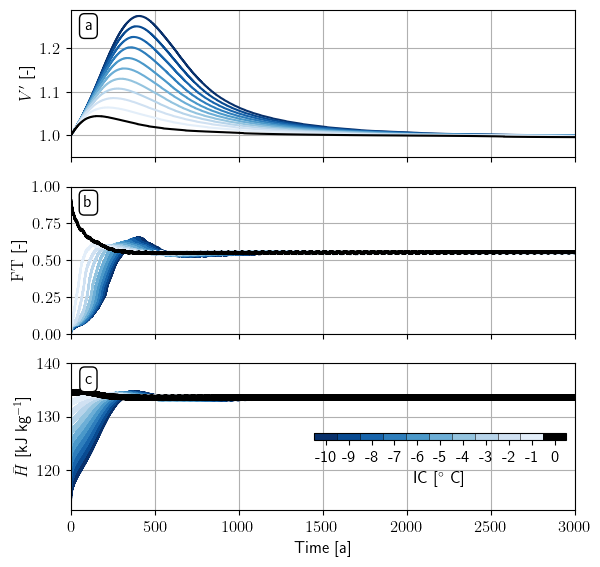

In [9]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(3,1, figsize=(6.5, 6.5), sharex=True)


# make the discrete colorbar, which should capture each individual parameter tested
cmap, norm, s_map, bounds = make_colorbar(IC_ds.IC, ref, IC=True)


for IC in IC_ds.IC: 
    
    color = cmap(norm(float(IC)))
                 
    ax[0].plot(IC_ds.t, IC_Vprime.sel(IC=IC), color=color)
    ax[1].plot(IC_ds.t, IC_FT.sel(IC=IC), color=color)
    ax[2].plot(IC_ds.t, IC_Hbar.sel(IC=IC), color=color)

axins1 = inset_axes(ax[2], width="50%", height="5%",  loc="center right")
cbar = fig.colorbar(s_map,
                cax=axins1, 
                label='IC [$^\circ$ C]',
                spacing='proportional',
                orientation="horizontal",
                ticks=s_map.get_array(),
                boundaries=bounds,
                drawedges=True,
                format="{x:.0f}"
               )

labels = ['a', 'b', 'c']
for i in range(3): 
    ax[i].text(0.035, 0.89, labels[i], 
               ha='center', va='center', transform=ax[i].transAxes, 
               bbox=dict(boxstyle="round", fc='w') )
    
[axes.grid() for axes in ax]

ax[0].set_ylabel("$V'$ [-]")
ax[1].set_ylabel(r'$\mathrm{FT}$ [-]');
ax[2].set_ylabel(r'$\bar{H}$ [kJ kg$^{-1}$]');
ax[2].set_xlabel('Time [a]');

ax[0].set_ylim(0.95, None)
ax[1].set_ylim(0, 1.0)
ax[2].set_ylim(None, 140)
ax[2].set_xlim(0, 3e3)

In [10]:
fig.savefig('figs/crmpt12/intial_condition.pdf')

In [ ]:
# close_off(C_firn_ds.C_firn).plot(marker='x')

plt.plot(close_off(C_firn_ds.C_firn))
plt.plot(np.linspace(5,40,8)[::-1])

In [ ]:
close_off(C_firn_ds.C_firn)[-2]

In [ ]:
f_dd_ds.sel(f_dd=0.0026).percent_temperate.plot(alpha=0.5)
f_dd_ds.sel(f_dd=0.0026).percent_temperate.rolling(t=10).mean().plot(color='k')



In [ ]:
# now get the water content along the base of the glacier
basal_ω = f_dd_ds['water content'].sel(f_dd=0.0026).isel(coord_2=0).persist()
# now calculte the fractional length using basal water content
temp_L  = xr.where(basal_ω > 0.001, 50/1e3, 0.0).sum('coord_1')
# need to deal with nan's, i.e. where the temperate length is zero
temp_L = xr.where(temp_L==0, np.nan, temp_L)

In [ ]:
temp_L.plot()

In [ ]:
calc_enthalpy(0, 1)

In [ ]:
w_en_ds = xr.open_mfdataset(ssd_fp+'*w_en*.zarr', engine='zarr', preprocess=preprocess)


In [ ]:
for w_en in w_en_ds.w_en: 
    

    plt.plot(w_en_ds.sel(w_en=w_en).X.isel(coord_2=-1), 
             np.gradient(w_en_ds.sel(w_en=w_en).vel_x.isel(coord_2=-1,t=-1)))

In [ ]:
idx = 77

d = src.depth.isel(coord_1=idx,t=-1)
v = src.vel_x.isel(coord_1=idx,t=-1)

fig, ax = plt.subplots(figsize=(3,6))
ax.plot(v,d, marker='x')

ax.invert_yaxis()

In [ ]:
d.compute()